# P5 Vehicle Detection using SVM with Averaging

In [1]:
# Import functions
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skimage.feature import hog
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D
print('function imports completed')

function imports completed


In [2]:
# 3D plotting function for color space exploration
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation
print('plot3d function created')

plot3d function created


In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[np.random.randint(0, len(car_list))])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
print('data_look function created')

data_look function created


In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
print('get_hog_features function created')

get_hog_features function created


In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
print('bin_spatial function created')

bin_spatial function created


In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
print('color_hist function created')

color_hist function created


In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
print('extract_features function created')

extract_features function created


In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
print('slide_window function created')

slide_window function created


In [9]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
print('draw_boxes function created')

draw_boxes function created


In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
print('single_img_features function created')

single_img_features function created


In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
print('search_windows function created')

search_windows function created


In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, conv='RGB2HSV', winsize=64):
    
    
    img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    
    hot_windows = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = winsize
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (winsize,winsize))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                BOX.current_fit.append([int(xbox_left), int(ytop_draw+ystart), int(win_draw), int(win_draw)])
   
    return draw_img, hot_windows
print('find_cars function created')

find_cars function created


In [13]:
# Function to add heat when a detection is made
def add_heat(heatmap):
    # Iterate through list of bboxes
#     for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    #print('Check if previous bestbox is empty', BOX.prev_fitted)    
    if BOX.prev_fitted==[]:
        BOX.prev_fitted = BOX.current_fit
        print('No previous bestbox filling with current and adding heat 1+')#, BOX.prev_fitted)
        for box in BOX.prev_fitted:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form [x,y,w,h]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            heatmap[y:y+h, x:x+w] += 1
            
#             BOX.detected = True
    else:
#         BOX.bestbox.append(BOX.current_fit)
        print('Previous bestbox exists, adding heat for previous bestbox 1+ and current boxes at 1+')#, BOX.prev_fitted)
        for box in BOX.prev_fitted:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form [x,y,w,h]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            heatmap[y:y+h, x:x+w] += 1
            
        for box in BOX.current_fit:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form [x,y,w,h]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            heatmap[y:y+h, x:x+w] += 1
        
#     plt.imshow(heatmap)
#     plt.show()
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
#     plt.imshow(heatmap)
#     plt.show()
    # Return thresholded map
    return heatmap

def cool_map(heatmap):
    # Cool off all pixels by 1
    heatmap[heatmap > 0] -=5
    return heatmap

def draw_labeled_bboxes(img, labels):
    box_all = []
    margin = 20
    
    detected_cars = range(1, labels[1]+1)
    # Iterate through all detected cars
    for car_number in detected_cars:
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        w = np.max(nonzerox)+margin - np.min(nonzerox)-margin
        h = np.max(nonzeroy)+margin - np.min(nonzeroy)-margin
        # Define a bounding box based on min/max x and y
        bbox_tuple = ((np.min(nonzerox)-margin, np.min(nonzeroy)-margin), (np.max(nonzerox)+margin, np.max(nonzeroy)+margin))
        bbox = [np.min(nonzerox)-margin, np.min(nonzeroy)-margin, w, h]
        bbox_labeled = [np.min(nonzerox)-margin, np.min(nonzeroy)-margin, w, h, car_number]
        
        # Recast in int dtype for groupRectangles
#         bbox = [int(x) for x in bbox]
        
        
        # Draw the box on the image
#         if BOX.averaged_boxes==[]:
#             cv2.rectangle(img, bbox_tuple[0], bbox_tuple[1], (0,0,255), 6)
#             #write box number above box
#             font = cv2.FONT_HERSHEY_SIMPLEX
#             cv2.putText(img,('Car #: ' + repr(car_number)), bbox_tuple[0], 
#                         font, .75,(0,255,0),2,cv2.LINE_AA)
#         else:
#             print('BOX.averaged_boxes just prior to drawing boxes', BOX.averaged_boxes)
#             # Draw the box on the image
#             for (x,y,w,h) in BOX.averaged_boxes:
#                 print('Drawing box...', (x,y,w,h))
#                 expand = 20
#                 if w<120:
#                     w=120
#                 if h<64:
#                     h=64
#                 cv2.rectangle(img, (x-expand, y-expand), (x + w + expand, y + h + expand), (0,0,255), 6)
#                 #write box number above box
#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 cv2.putText(img,('Car #: ' + repr(car_number)), (x,y-10), 
#                             font, .75,(0,255,0),2,cv2.LINE_AA)
        
        #write box number above box
        cv2.rectangle(img, bbox_tuple[0], bbox_tuple[1], (0,0,255), 6)
        #write box number above box
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,('Car #: ' + repr(car_number)), bbox_tuple[0], 
                    font, .75,(0,255,0),2,cv2.LINE_AA)
        
        # assign to current fit
#         box_all.append(bbox)
        
        
        #append current fits to lastn_bestboxes
#         append_best(bbox_labeled)
        
        # Append current fits to best box
#         print('BOX.bestbox before append', BOX.bestbox)
#         BOX.bestbox.append(bbox)
#         print('BOX.bestbox after append', BOX.bestbox)
       
    
# ###################################################################################        
# # Testing this section remove if not working        
#         box_grouped, _ = cv2.groupRectangles(box_all, 1, 1.3)
#     #     box_grouped =[]
#         print('Grouped Boxes', box_grouped)
#         if box_grouped==():
#             print('Grouped boxes empty')
#         else:
#             BOX.bestbox = box_grouped
#             print('BOX.bestbox', BOX.bestbox)

#         print('BOX.bestbox just prior to drawing boxes', BOX.bestbox)
#         # Draw the box on the image
#         for (x,y,w,h) in BOX.bestbox:
#             print('Drawing box...', (x,y,w,h))
#             expand = 20
#             if w<120:
#                 w=120
#             if h<64:
#                 h=64
#             cv2.rectangle(img, (x-expand, y-expand), (x + w + expand, y + h + expand), (0,0,255), 6)
# ###########################################################################################################    

        
## IF BROKE UNCOMMENT########################        
#     if not BOX.prev_fit_filled:
#         print('prev_fit_filled = False')
#         group_thresh = 0  # no previous frame: keep all form heat
#         BOX.prev_fitted = BOX.bestbox
# #         print('BOX.prev_fitted filled with .bestbox', BOX.prev_fitted)
#         BOX.prev_fit_filled = True
#     else:
#         print('appending previous bestboxes...')
#         for box in BOX.prev_fitted:
#             if isinstance(box, np.ndarray):
#                 box = box.tolist()
#             print('Box to be appended', box)
#             box_all.append(box)
#             print(box_all,'...\n')
#         group_thresh = 1  # previous frame + heat       
        
#     box_grouped, _ = cv2.groupRectangles(box_all, group_thresh, 1.3)
# #     box_grouped =[]
#     print('Grouped Boxes', box_grouped)
#     if box_grouped==():
#         print('Grouped boxes empty')
#     else:
#         BOX.bestbox = box_grouped
        
##########################################################################################################        
        
        
#         print('BOX.bestbox', BOX.bestbox)
    
#     print('BOX.bestbox just prior to drawing boxes', BOX.bestbox)
#     # Draw the box on the image
#     for (x,y,w,h) in BOX.bestbox:
#         print('Drawing box...', (x,y,w,h))
#         expand = 20
#         if w<120:
#             w=120
#         if h<64:
#             h=64
# #         cv2.rectangle(img, (x-expand, y-expand), (x + w + expand, y + h + expand), (0,0,255), 6)
############################################################################################################

    BOX.prev_fitted = BOX.bestbox  
    BOX.bestbox = []
    BOX.current_fit = []  
   

    # Return the image
    return img
print('add_heat, apply_threshold, cool_map, draw_labeled_bboxes functions created')

add_heat, apply_threshold, cool_map, draw_labeled_bboxes functions created


In [14]:
# Averages lastn heatmap fits to give the current running average
def averager():
    BOX.averaged_boxes = []
    lastn=np.array((BOX.lastn_bestboxes))
#     print('Averager called on these .lastn_bestboxes', lastn)
    ncars = (np.ptp(lastn[:,4])+1)
    dict_averages_bycar = {}
    for n in range(1,ncars+1):
        dict_averages_bycar['%s' % n] = np.zeros((1,4))
        k=1
        for i, car in enumerate(lastn):
            if k==1:
                dict_averages_bycar['%s' % n] = np.asarray([car[:4]])
#                 print('k=',k, dict_averages_bycar)
            if car[4]==n:
                dict_averages_bycar['%s' % n] = (dict_averages_bycar['%s' % n] * (k) + [car[:4]]) / (k+1)
                k+=1
        bbox = [int(x) for x in dict_averages_bycar['%s' % n][0]]
        BOX.averaged_boxes.append(bbox)
    return dict_averages_bycar
print('averager function created') 

averager function created


In [15]:
# Appends the most recent heatmap fits up to n total
def append_best(labeled, n=20):
    if len(BOX.lastn_bestboxes) < n:
#         print('labeled box being appended to lastn_bestboxes = ', labeled)
        BOX.lastn_bestboxes.append(labeled)
    else:
        del BOX.lastn_bestboxes[:1]
        BOX.lastn_bestboxes.append(labeled)
print('append_best function created')

append_best function created


In [16]:
# Function to convert color to the value of conv
def convert_color(img, conv='RGB2HSV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
print('convert_color function created')

convert_color function created


In [17]:
# Define a class to receive the characteristics of each line detection
class Box():
    def __init__(self, img):
        # was the box fit in the last iteration?
        self.detected = False  
        # Last bestbox fit
        self.prev_fitted = [] 
        #Previous fit empty boolean
        self.prev_fit_filled = False
        #current bestbox drawn around heatmap
        self.bestbox = []    
        #box values for the most recent fit
        self.current_fit = []
        # Store previous heatmap
        self.prev_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        # Store last n bestbox fits
        self.lastn_bestboxes = []
        # Averaged bestbox for last n fits
        self.averaged_boxes = []
#         # Bestboxes label for each car
#         self.labled_bestboxes = []
        
print('Box() class created')

Box() class created


In [18]:
# class Car()
#     def __init__(self)
#         # Store last n bestbox fits
#         self.lastn_bestboxes = None
#         # Averaged bestbox for last n fits
#         self.averaged_box = None

## Intial testing on images

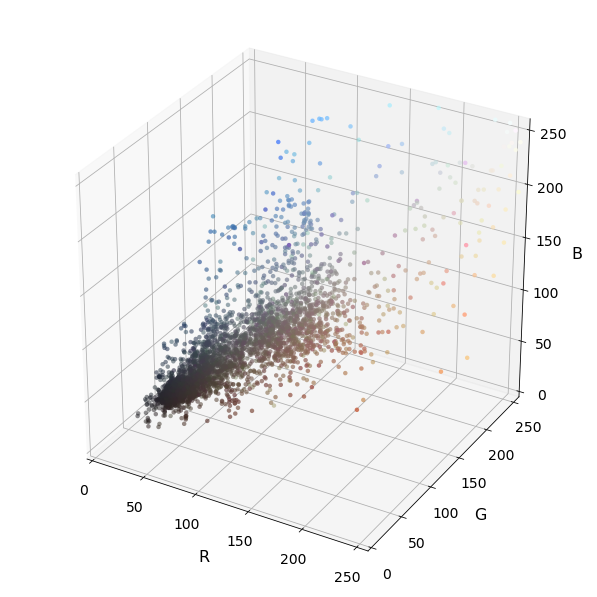

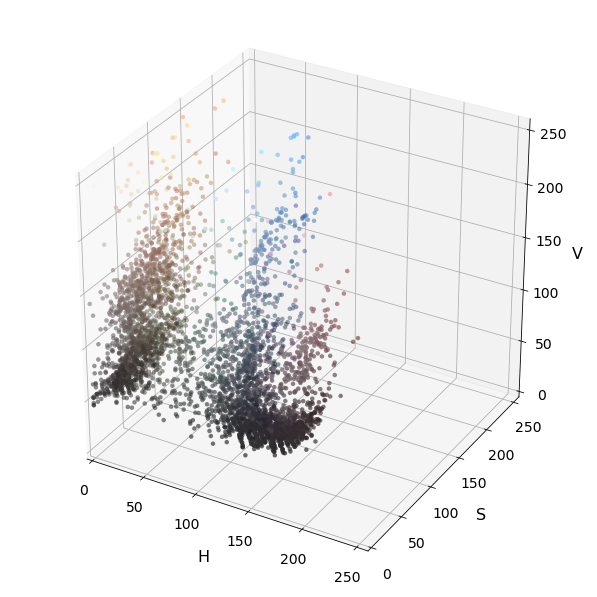

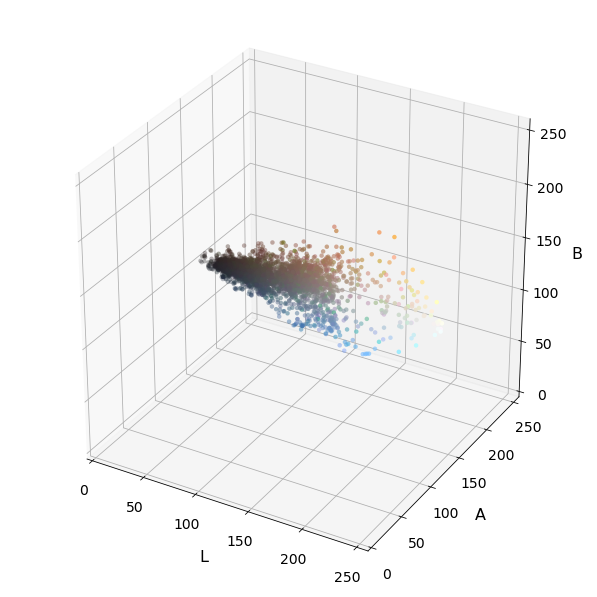

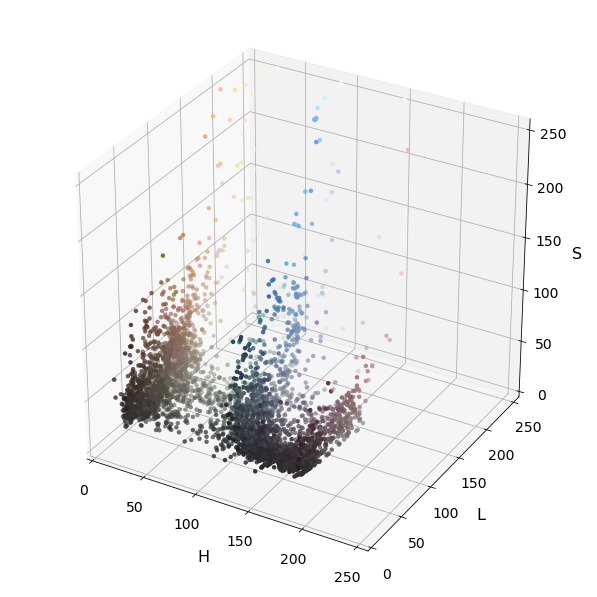

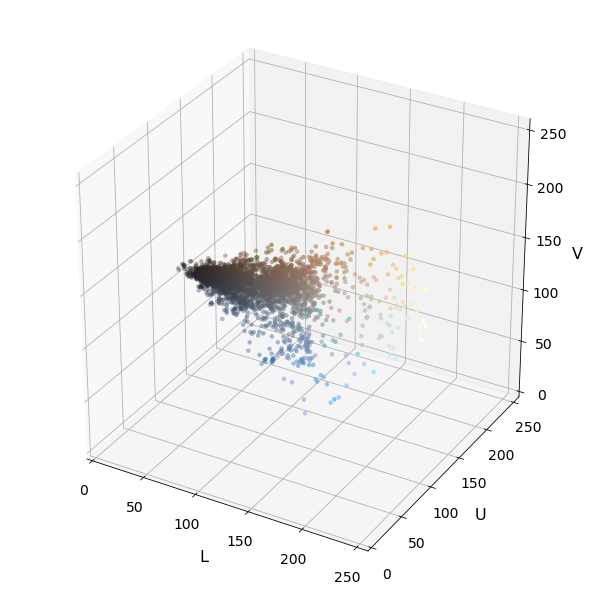

In [19]:
# Read a color image
img = cv2.imread("./test_images/3.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LAB = cv2.cvtColor(img_small, cv2.COLOR_BGR2LAB)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LAB, img_small_rgb, axis_labels=list("LAB"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

data_look function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


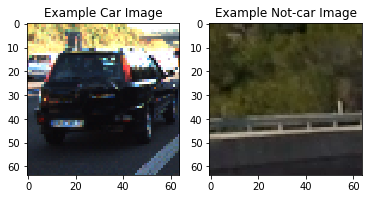

In [20]:
# Explore the training data
images = glob.glob('./training_data/**/*.png', recursive=True)
# print('image paths', images)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    if 'vehicles' in image and 'non-' not in image:
        cars.append(image)
        
# print('Car list', cars)
#   
data_info = data_look(cars, notcars)

print('data_look function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig1 = plt.figure(1)
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()
# fig1.savefig("./output_images/carnotcar.png", transparent = False)

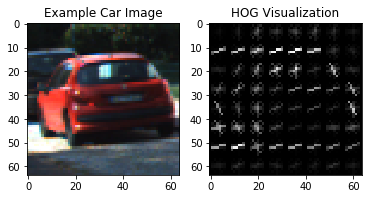

In [21]:
## Test the get_hog_features() function and example output
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig2 = plt.figure(2)
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()
# fig2.savefig("./output_images/carHOG.png", transparent = False)

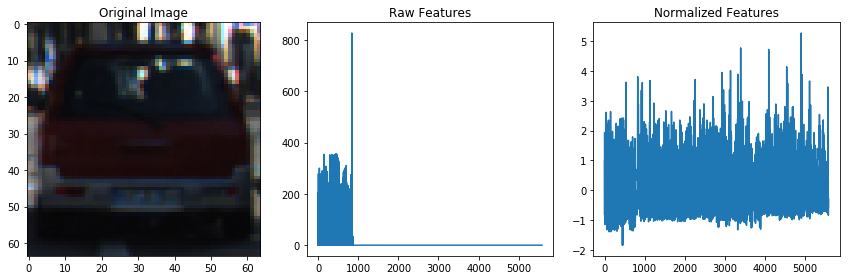

105.43 Seconds to extract features...


In [22]:
## Test extract_features() function and show example
### TODO: Tweak these parameters and see how the results change.
# Check the training time for the SVC
t=time.time()
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 36    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390, 650] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space, spatial_size, hist_bins, orient, 
                                pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins, orient, 
                                pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig3 = plt.figure(3, figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig3.tight_layout()
    plt.show()
#     fig3.savefig("./output_images/carrawnorm.png", transparent = False)
else: 
    print('Your function only returns empty feature vectors...')


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

In [23]:
## Test training

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: (16, 16) and 36 histogram bins
Feature vector length: 5580


In [24]:
# Test classifier with different parameters
# #######################################################################################
# clf = SVC()


# # Utility function to report best scores
# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")


# # specify parameters and distributions to sample from
# param_dist = {"gamma": [.001,.0001],
#               "C": [1,10],
#               "kernel": ['rbf'],}

# # run randomized search
# n_iter_search = 4
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search)

# start = time.time()
# random_search.fit(X_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))
# report(random_search.cv_results_)
# #################################################################################
#Parameter tuning for classifer
# tuned_parameters = [{'C': [1, 10], 'kernel': ['linear']}, 
#               {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},]

# scores = ['accuracy','precision_macro', 'recall_macro']

# for score in scores:
#     t=time.time()
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(C=1), tuned_parameters, n_jobs=4, cv=5,
#                        scoring='%s' % score)
#     clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()
# sorted(clf.cv_results_.keys())

#     t2 = time.time()
#     print(round(t2-t, 2), 'Seconds to tune SVC %s...' % score)

In [25]:
#Train support vector classifier with the tuned parameters
# Use a linear SVC 
svc = LinearSVC(C=100)#SVC(C=10, kernel='rbf', gamma=.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts    :  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.004 Seconds to predict 10 labels with SVC


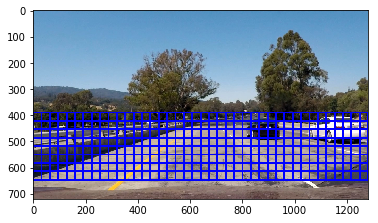

In [26]:
## Sliding window test
testimg = mpimg.imread('./test_images/test1.jpg')
y_start_stop = [390, 650] # Min and max in y to search in slide_window()
windows = slide_window(testimg, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(testimg, windows, color=(0, 0, 255), thick=6)                    
fig4 = plt.figure(4)
plt.imshow(window_img)
plt.show()

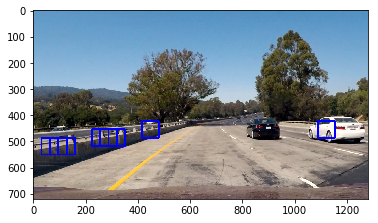

In [27]:
## Test search windows function
draw_image = np.copy(testimg)
hot_windows = search_windows(testimg, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig5 = plt.figure(5)
plt.imshow(window_img)
plt.show()

In [28]:
 fig5.savefig("./output_images/rawdetections.png", transparent = False)

BOX.current []


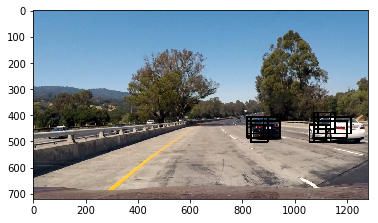

box [816, 406, 64, 64]
box [816, 422, 64, 64]
box [832, 406, 64, 64]
box [832, 422, 64, 64]
box [832, 438, 64, 64]
box [880, 406, 64, 64]
box [880, 422, 64, 64]
box [1056, 438, 64, 64]
box [1072, 390, 64, 64]
box [1072, 406, 64, 64]
box [1072, 422, 64, 64]
box [1072, 438, 64, 64]
box [1088, 390, 64, 64]
box [1088, 406, 64, 64]
box [1136, 422, 64, 64]
box [1152, 406, 64, 64]


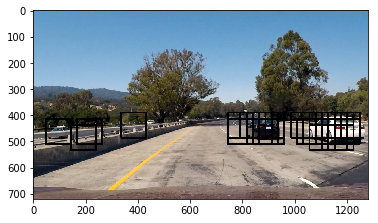

box [816, 406, 64, 64]
box [816, 422, 64, 64]
box [832, 406, 64, 64]
box [832, 422, 64, 64]
box [832, 438, 64, 64]
box [880, 406, 64, 64]
box [880, 422, 64, 64]
box [1056, 438, 64, 64]
box [1072, 390, 64, 64]
box [1072, 406, 64, 64]
box [1072, 422, 64, 64]
box [1072, 438, 64, 64]
box [1088, 390, 64, 64]
box [1088, 406, 64, 64]
box [1136, 422, 64, 64]
box [1152, 406, 64, 64]
box [48, 414, 96, 96]
box [144, 438, 96, 96]
box [168, 414, 96, 96]
box [336, 390, 96, 96]
box [744, 390, 96, 96]
box [744, 414, 96, 96]
box [792, 390, 96, 96]
box [816, 390, 96, 96]
box [816, 414, 96, 96]
box [840, 390, 96, 96]
box [840, 414, 96, 96]
box [864, 390, 96, 96]
box [864, 414, 96, 96]
box [984, 390, 96, 96]
box [1008, 414, 96, 96]
box [1032, 414, 96, 96]
box [1056, 390, 96, 96]
box [1056, 414, 96, 96]
box [1056, 438, 96, 96]
box [1080, 390, 96, 96]
box [1080, 414, 96, 96]
box [1104, 390, 96, 96]
box [1104, 414, 96, 96]
box [1104, 438, 96, 96]
box [1128, 390, 96, 96]
box [1128, 414, 96, 96]
box [1128, 438

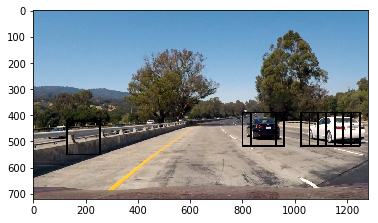

box [816, 406, 64, 64]
box [816, 422, 64, 64]
box [832, 406, 64, 64]
box [832, 422, 64, 64]
box [832, 438, 64, 64]
box [880, 406, 64, 64]
box [880, 422, 64, 64]
box [1056, 438, 64, 64]
box [1072, 390, 64, 64]
box [1072, 406, 64, 64]
box [1072, 422, 64, 64]
box [1072, 438, 64, 64]
box [1088, 390, 64, 64]
box [1088, 406, 64, 64]
box [1136, 422, 64, 64]
box [1152, 406, 64, 64]
box [48, 414, 96, 96]
box [144, 438, 96, 96]
box [168, 414, 96, 96]
box [336, 390, 96, 96]
box [744, 390, 96, 96]
box [744, 414, 96, 96]
box [792, 390, 96, 96]
box [816, 390, 96, 96]
box [816, 414, 96, 96]
box [840, 390, 96, 96]
box [840, 414, 96, 96]
box [864, 390, 96, 96]
box [864, 414, 96, 96]
box [984, 390, 96, 96]
box [1008, 414, 96, 96]
box [1032, 414, 96, 96]
box [1056, 390, 96, 96]
box [1056, 414, 96, 96]
box [1056, 438, 96, 96]
box [1080, 390, 96, 96]
box [1080, 414, 96, 96]
box [1104, 390, 96, 96]
box [1104, 414, 96, 96]
box [1104, 438, 96, 96]
box [1128, 390, 96, 96]
box [1128, 414, 96, 96]
box [1128, 438

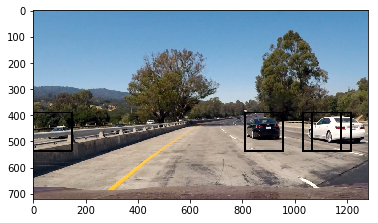

box [816, 406, 64, 64]
box [816, 422, 64, 64]
box [832, 406, 64, 64]
box [832, 422, 64, 64]
box [832, 438, 64, 64]
box [880, 406, 64, 64]
box [880, 422, 64, 64]
box [1056, 438, 64, 64]
box [1072, 390, 64, 64]
box [1072, 406, 64, 64]
box [1072, 422, 64, 64]
box [1072, 438, 64, 64]
box [1088, 390, 64, 64]
box [1088, 406, 64, 64]
box [1136, 422, 64, 64]
box [1152, 406, 64, 64]
box [48, 414, 96, 96]
box [144, 438, 96, 96]
box [168, 414, 96, 96]
box [336, 390, 96, 96]
box [744, 390, 96, 96]
box [744, 414, 96, 96]
box [792, 390, 96, 96]
box [816, 390, 96, 96]
box [816, 414, 96, 96]
box [840, 390, 96, 96]
box [840, 414, 96, 96]
box [864, 390, 96, 96]
box [864, 414, 96, 96]
box [984, 390, 96, 96]
box [1008, 414, 96, 96]
box [1032, 414, 96, 96]
box [1056, 390, 96, 96]
box [1056, 414, 96, 96]
box [1056, 438, 96, 96]
box [1080, 390, 96, 96]
box [1080, 414, 96, 96]
box [1104, 390, 96, 96]
box [1104, 414, 96, 96]
box [1104, 438, 96, 96]
box [1128, 390, 96, 96]
box [1128, 414, 96, 96]
box [1128, 438

In [29]:
## Test HOG subsampling

ystart = 390
ystop = 656
scales = [1.0, 1.5, 2.0, 2.3]
ystarts = [390, 390, 390, 390]
ystops = [650, 650, 650, 650]
box_list = []
BOX = Box(testimg)
print('BOX.current', BOX.current_fit)
for i, scale in enumerate(scales): 
    out_img, bboxes = find_cars(testimg, ystarts[i], ystops[i], scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, conv='RGB2HSV', winsize=64)
    fig = plt.figure(i+20)
    plt.imshow(out_img)
    plt.show()
    fig.savefig("./output_images/scaling%s.png" % i, transparent = False)
    for box in BOX.current_fit:
        print('box', box)
        box_list.append(box)
    
print('List of window coords',box_list)

No previous bestbox filling with current and adding heat 1+


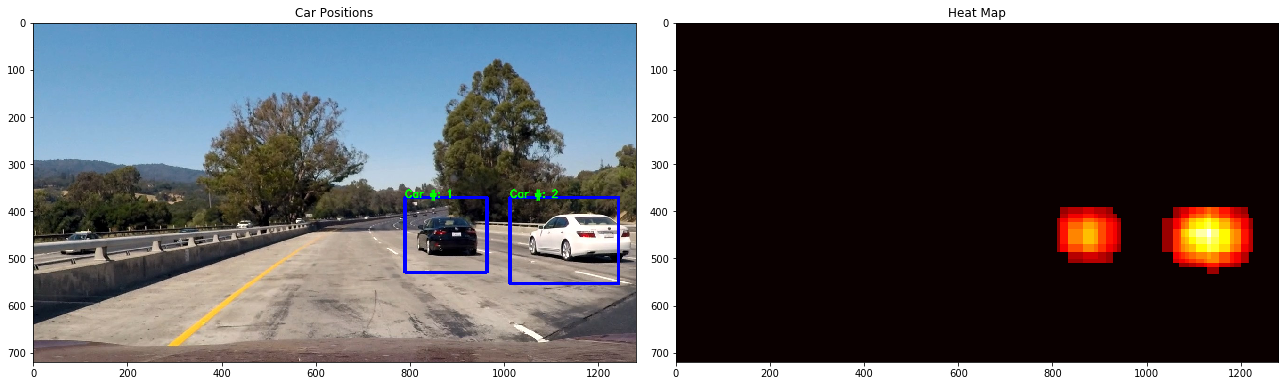

In [30]:
## Test heat map of hot windows

# Create heat image with zeros
heat = np.zeros_like(testimg[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(testimg), labels)

fig7 = plt.figure(7, figsize=(18,9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig7.tight_layout()
plt.show()

In [34]:
# j=1
# Pipeline for images
def detect_vehicles(img):
#     global j
    ## Test HOG subsampling

    ystart = 390
    ystop = 656
    scales = [1.0, 1.5, 2.0, 2.3]
    ystarts = [390, 390, 390, 390]
    ystops = [650, 650, 650, 650]
#     scales = [1.0, 1.5, 2.0, 2.5]
#     ystarts = [390, 390, 390, 390]
#     ystops = [550, 550, 600, 650]
    box_list = []
#     out_img = np.copy(img)
    for i, scale in enumerate(scales): 
        out_img, bboxes = find_cars(img, ystarts[i], ystops[i], scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, conv='RGB2HSV', winsize=64)


### Grouping of current_fit boxes
#     print('detect_vehicles current_fit = ',BOX.current_fit)
    boxes = []
    for box in BOX.current_fit:
        if isinstance(box, np.ndarray):
            box = box.tolist()
            boxes.append(box)
        else:
            boxes.append(box)
    box_grouped, _ = cv2.groupRectangles(boxes, 1, 1.3)
#     print('detect_vehicles Grouped Boxes', box_grouped)
    
####Assign grouped boxes into bestfit
    boxes = []
    for box in box_grouped:
        if isinstance(box, np.ndarray):
            box = box.tolist()
            boxes.append(box)
        else:
            boxes.append(box)
    BOX.bestbox = boxes
            
#     for box in BOX.current_fit:
# #             print('box append to current_fit', box)
#         box_list.append(box)
            
    # Create heat image with zeros
    heat = BOX.prev_heatmap
#     heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
#     dict_averages_bycar = averager()
    
    # Cool heatmap and store to previous
    cooled = cool_map(heatmap)
    BOX.prev_heatmap = cooled
#     superimposed = cv2.addWeighted(draw_img, 1, heatmap, 0.3, 0)
    
    fig8 = plt.figure(8, figsize=(18,9))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig8.tight_layout()
    plt.show()
    fig8.savefig("./output_images/heatmapseq%s.png" % j, transparent = False)
#     j+=1
    return draw_img
print('detect_vehicles function created')

detect_vehicles function created


In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
BOX = Box(testimg)
project_output = 'test_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

In [ ]:
# HTML("""
# <video width="800" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(project_output))

In [ ]:
BOX = Box(testimg)
project_output = 'project_output_heatmapcooling2.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


In [ ]:
HTML("""
<video width="800" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))